# Predictive Quality Control for Manufacturing

## Importing Required Libraries

In [172]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

from scipy.stats import gaussian_kde
import os

## Data Preprocessing

In [173]:
def preprocess_data(file_path):
    # Load dataset
    data = pd.read_csv(file_path)

    # Check for non-numeric columns and attempt encoding
    for column in data.select_dtypes(include=['object']).columns:
        # If the column is categorical, encode it
        if data[column].dtype == 'object':
            # Option 1: Label encoding (if there are few unique values)
            label_encoder = LabelEncoder()
            data[column] = label_encoder.fit_transform(data[column])
    
    # Separate features (X) and target (y)
    X = data.drop(columns=['y1', 'y2'])  # Assuming 'y1' and 'y2' are the target columns
    y = data[['y1', 'y2']]  # Adjust this as needed
    
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Standardize the input data (features)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    return X_train, X_test, y_train, y_test, data

In [174]:
def preprocess_data_From_Frame(data, key):
    

    # Check for non-numeric columns and attempt encoding
    for column in data.select_dtypes(include=['object']).columns:
        # If the column is categorical, encode it
        if data[column].dtype == 'object':
            # Option 1: Label encoding (if there are few unique values)
            label_encoder = LabelEncoder()
            data[column] = label_encoder.fit_transform(data[column])
    
    # Separate features (X) and target (y)
    X = data.drop(columns=[key])  
    y = data[[key]]  
    
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Standardize the input data (features)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    return X_train, X_test, y_train, y_test, data

## Exploratory Data Analysis (EDA)

In [175]:
def perform_eda(data):
    plt.figure(figsize=(12, 8))
    sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Feature Correlation Heatmap')
    plt.show()

    for col in ['u1', 'u2', 'u3', 'u4', 'u5']:
        try: 
            sns.scatterplot(x=data[col], y=data['y1'])
            plt.title(f'{col} vs Tension (T1)')
            plt.xlabel(col)
            plt.ylabel('Tension T1')
            plt.show()

            sns.scatterplot(x=data[col], y=data['y2'])
            plt.title(f'{col} vs Tension (T3)')
            plt.xlabel(col)
            plt.ylabel('Tension T3')
            plt.show()
        except:
            pass

## Predictive Modeling

In [176]:
def train_model(X_train, y_train):
    model = linear_model.Ridge(alpha=0.5)#LinearRegression()
    model.fit(X_train, y_train)
    joblib.dump(model, 'tension_prediction_model.pkl')
    return model

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred, multioutput='uniform_average')
    return mse, r2, y_pred

Classification

In [177]:
def classify_data(data: pd.DataFrame, key, threshold, threshold2):
    classes = []
    for x in range(len(data['u1'])):
        if data[key][x] > threshold or data['y2'][x] > threshold2:
            classes.append(1)
        else:
            classes.append(0)
    classi = pd.Series(classes)
    data = data.assign(classi=classi.values)
    data = data.drop(columns=['y1', 'y2'])
    return data

def train_classifier(x_train, y_train):
    classifier = SVC(kernel='linear')
    classifier.fit(x_train, y_train)
    return classifier

def evaluate_classifier(classifier, x_test, y_test):
    y_pred = classifier.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy:.2f}')
    print('Classification Report:\n', classification_report(y_test, y_pred))

## Quality Control Integration

In [178]:
def plot_spc_chart(y_test, threshold, title):
    plt.figure(figsize=(10, 5))
    plt.plot(y_test.values, label='Actual T1', marker='o')
    plt.axhline(y_test.mean(), color='r', linestyle='dashed', label='Mean T1')
    plt.axhline(threshold, color='b', linestyle='solid', label='Upper Control Line')
    plt.axhline(-threshold, color='b', linestyle='solid', label='Lower Control Line')


    plt.xlabel('Sample Index')
    plt.ylabel('Tension')
    plt.legend()
    plt.title('Statistical Process Control Chart for ' + title)
    plt.show()

# Alarms

In [179]:
def trigger_alarm(y_pred, threshold=1.5):
    alarms = y_pred > threshold
    if np.any(alarms):
        print("Alarm triggered! Predicted values exceed the threshold.")
    else:
        print("No alarm. All predicted values are within the threshold.")

## Six Sigma Framework

In [180]:
def calculate_dpmk(y_actual, y_predicted, thresholdy1, thresholdy2):
    # Calculating Defects Per Million Opportunities (DPMO)
    defects_t1 = np.sum(np.abs(y_actual[:, 0] - y_predicted[:, 0]) > thresholdy1)
    defects_t3 = np.sum(np.abs(y_actual[:, 1] - y_predicted[:, 1]) > thresholdy2)
    
    opportunities = len(y_actual) * 2  # T1 and T3
    defects = defects_t1 + defects_t3
    
    return (defects / opportunities) * 1_000_000

def calculate_cpk(data, usl, lsl):
    # Calculating Process Capability Index (Cpk)
    mean = data.mean()
    std_dev = data.std()
    cpu = (usl - mean) / (1.5 * std_dev)
    cpl = (mean - lsl) / (1.5 * std_dev)
    
    return min(cpu, cpl)

In [181]:
def findOutliers(dataframe, threshold, key) -> pd.DataFrame:
    if key not in dataframe.columns:
        raise ValueError("The DataFrame does not contain a 'y1' column.")

    outliers = dataframe[(dataframe[key] > threshold)] #| (dataframe[key] < -1*threshold) Only positive for testing
    

    #outliers = outliers[(outliers['u1'] > 0)]
    
    return outliers

In [182]:
def onlyPositive(outliers) -> pd.DataFrame:

    outliers = outliers[(outliers['u5'] > 0)]
    outliers = outliers[(outliers['u2'] > 0)]
    outliers = outliers[(outliers['u4'] < 0)]
    
    return outliers

In [183]:
def onlyNegative(outliers) -> pd.DataFrame:

    outliers = outliers[(outliers['u5'] < 0)]
    
    return outliers

In [184]:
def plot_distribution(data, column, title):
    plt.figure(figsize=(12, 6))
    
    # Plot histogram with more bins
    sns.histplot(data[column], kde=False, bins=50, color='blue', label=f'{column} Histogram')
    
    plt.title(f'Distribution of {title}')
    plt.xlabel(f'{column}')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

In [185]:
def plot_kde_manual(data, column):
    x_values = np.linspace(data[column].min(), data[column].max(), 100)
    kde = gaussian_kde(data[column])  # Compute KDE
    y_values = kde(x_values)

    plt.figure(figsize=(8, 4))
    plt.hist(data[column], bins=30, density=True, alpha=0.5, color='blue', edgecolor='black', label='Histogram')
    plt.plot(x_values, y_values, color='red', label='KDE')
    
    # Axis Labels
    plt.xlabel("Value")  
    plt.ylabel("Density")
    plt.title(f'KDE of {column}')
    plt.legend()
    plt.show()

## Running the Workflow

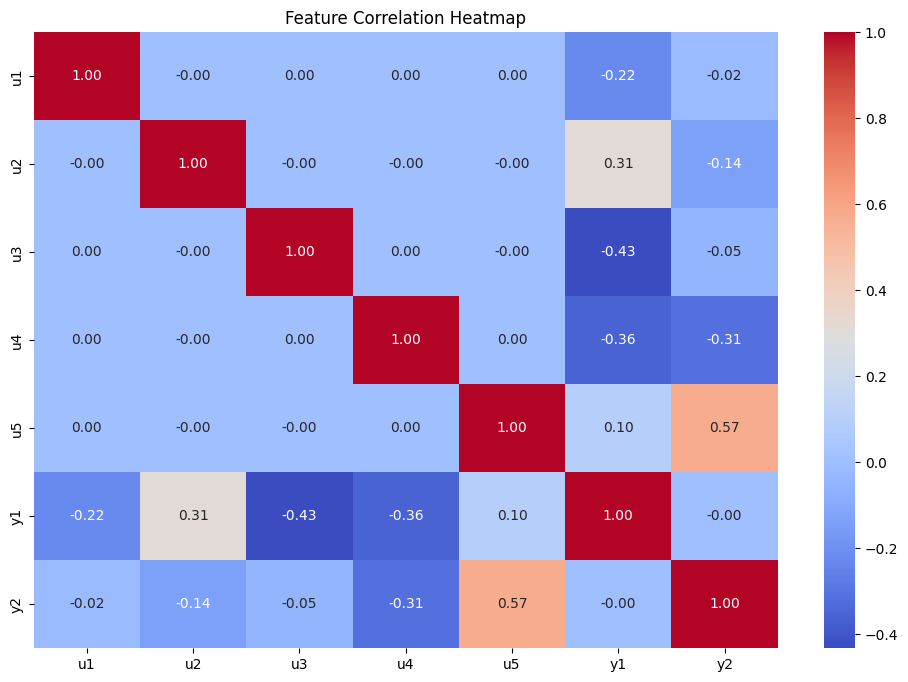

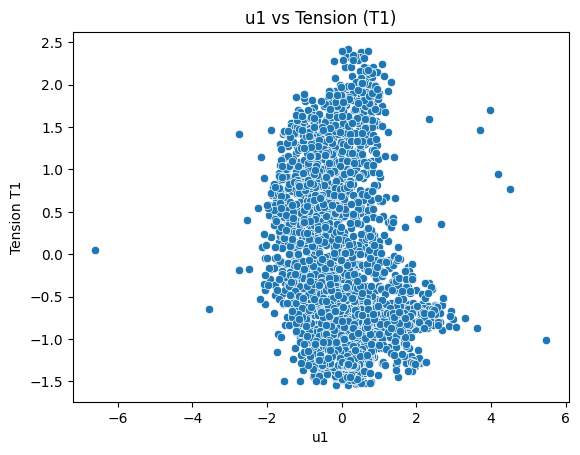

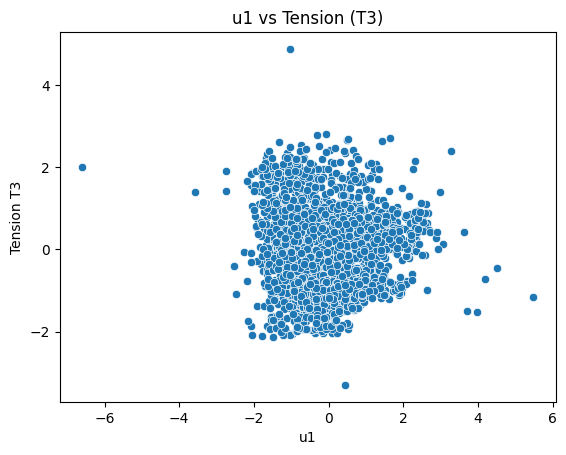

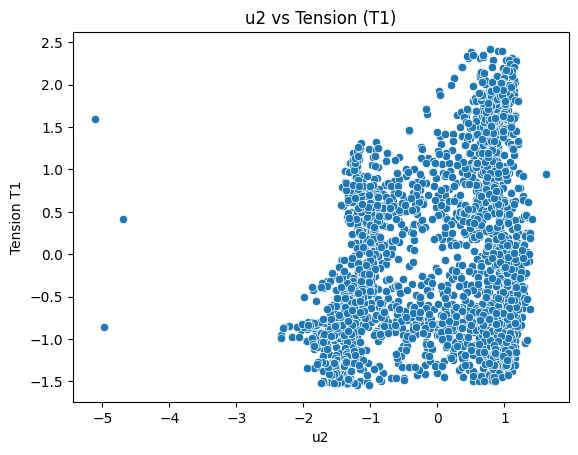

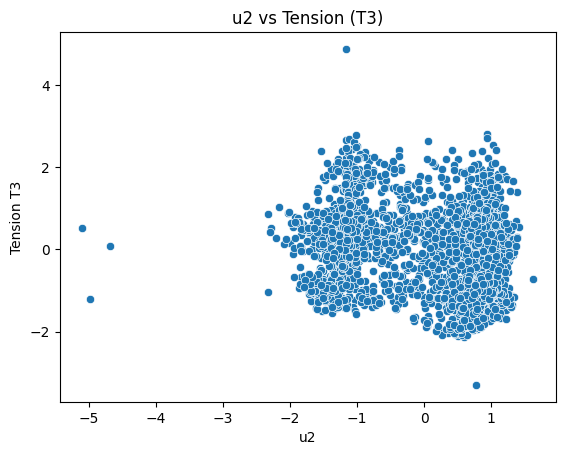

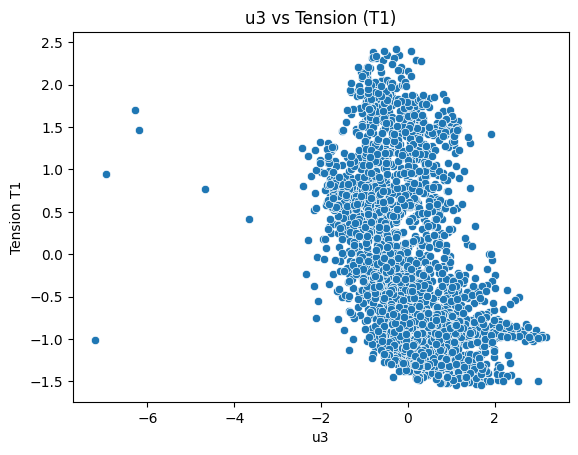

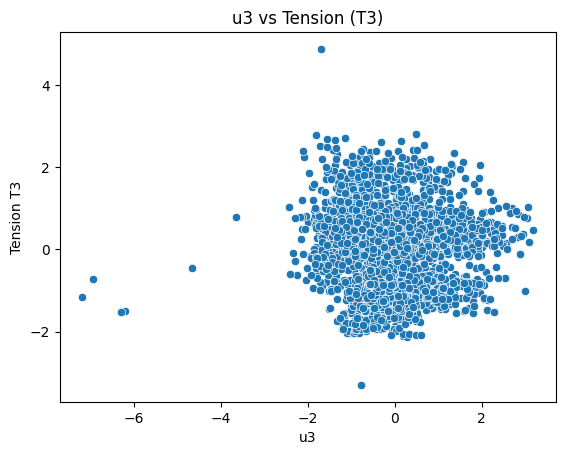

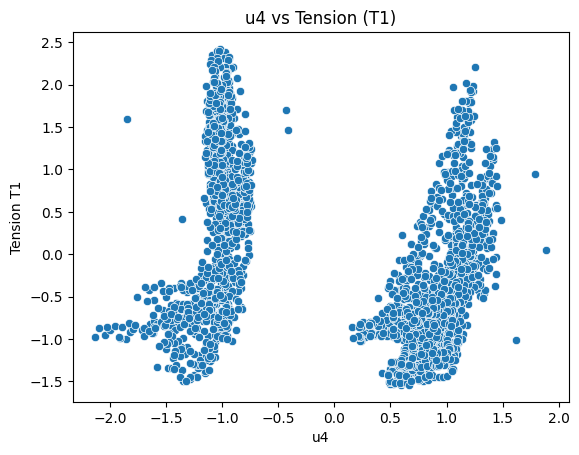

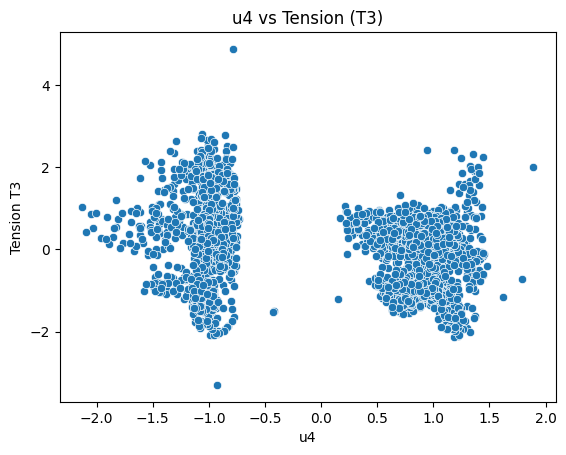

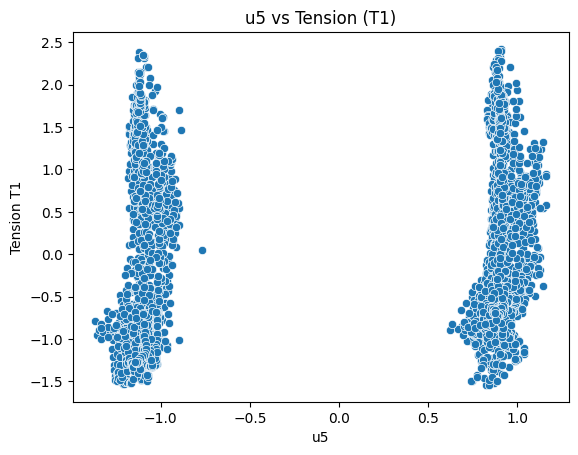

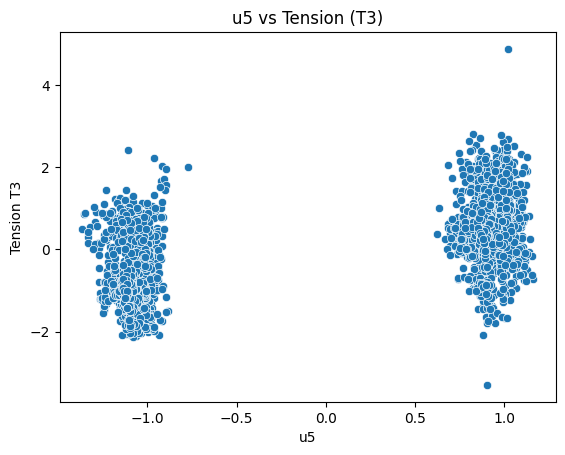

Model Performance: MSE = 0.4890, R² Score = 0.4799
Threshold = 1.491755509241037


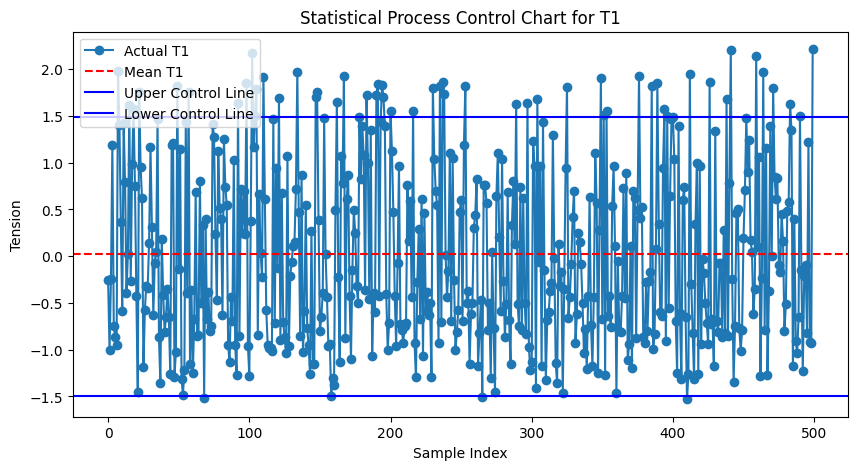

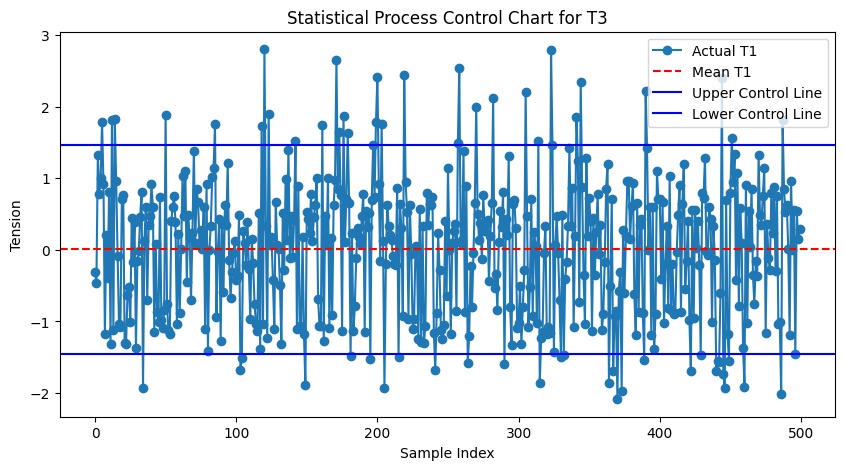

Alarm triggered! Predicted values exceed the threshold.


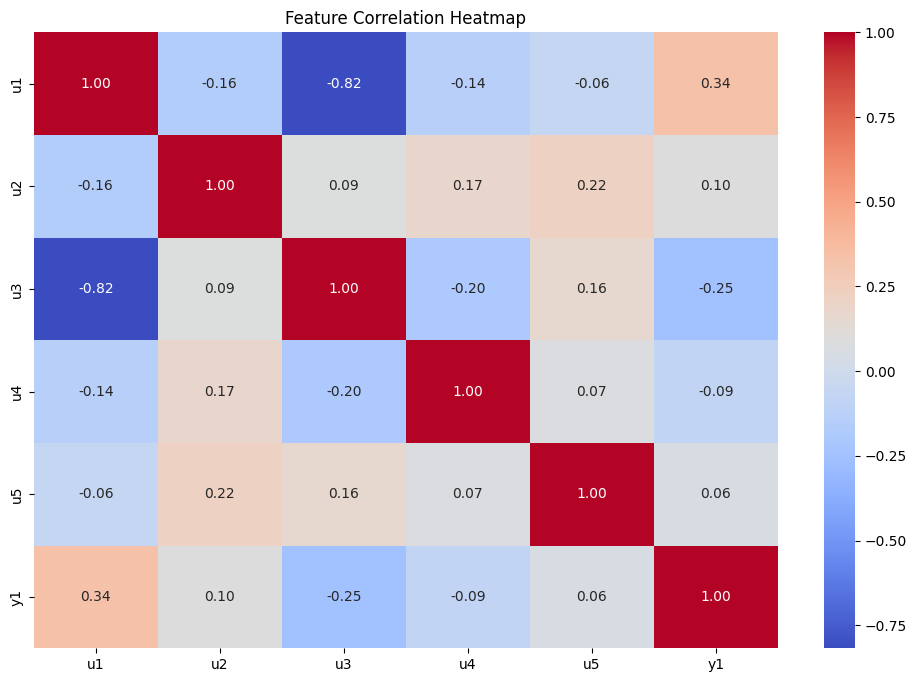

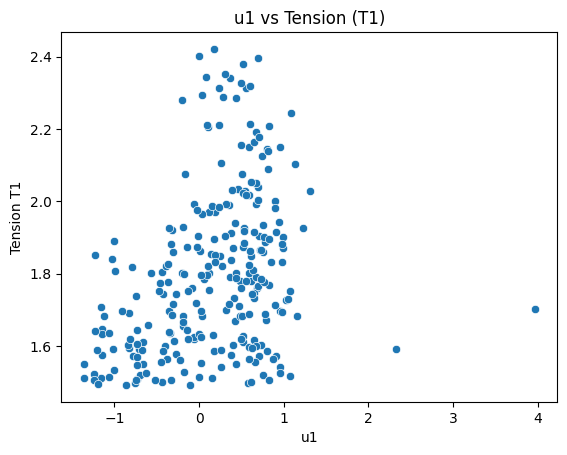

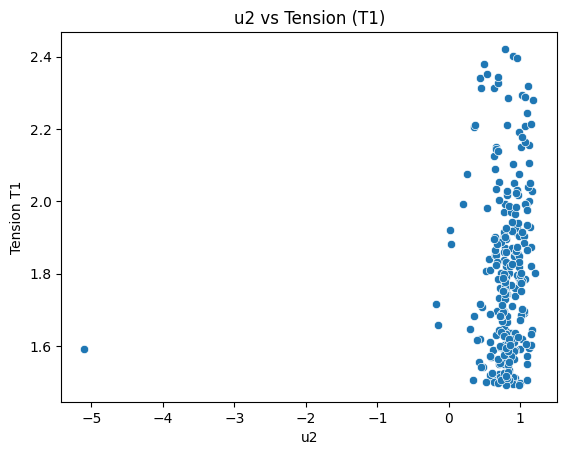

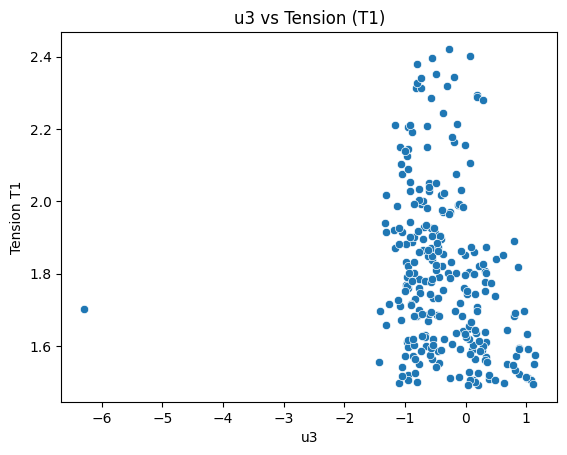

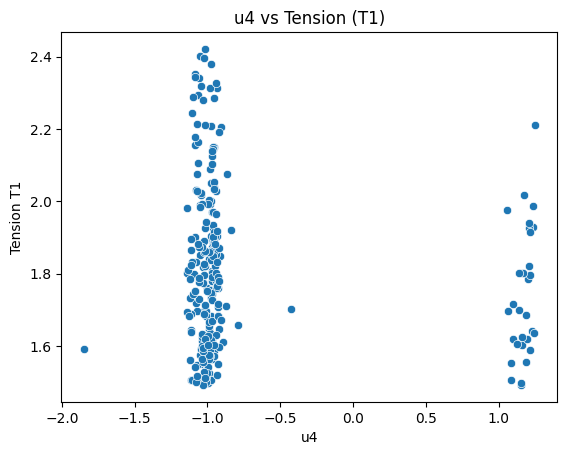

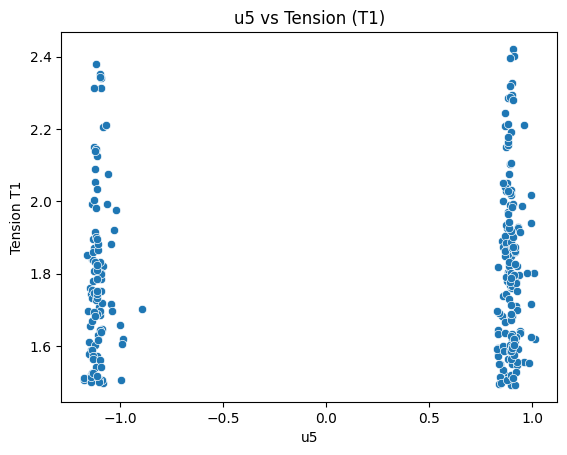

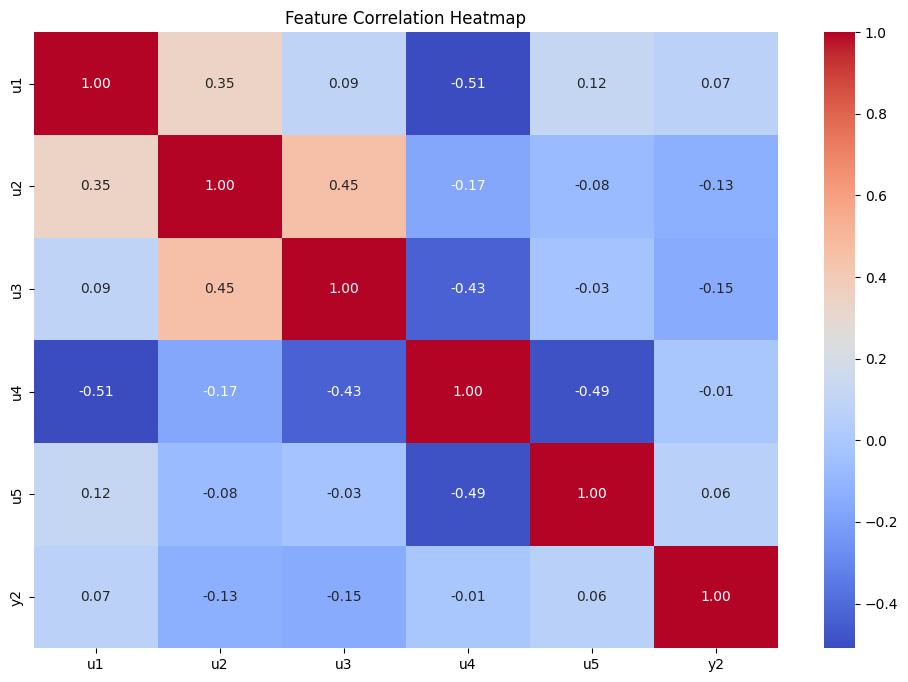

positive U5


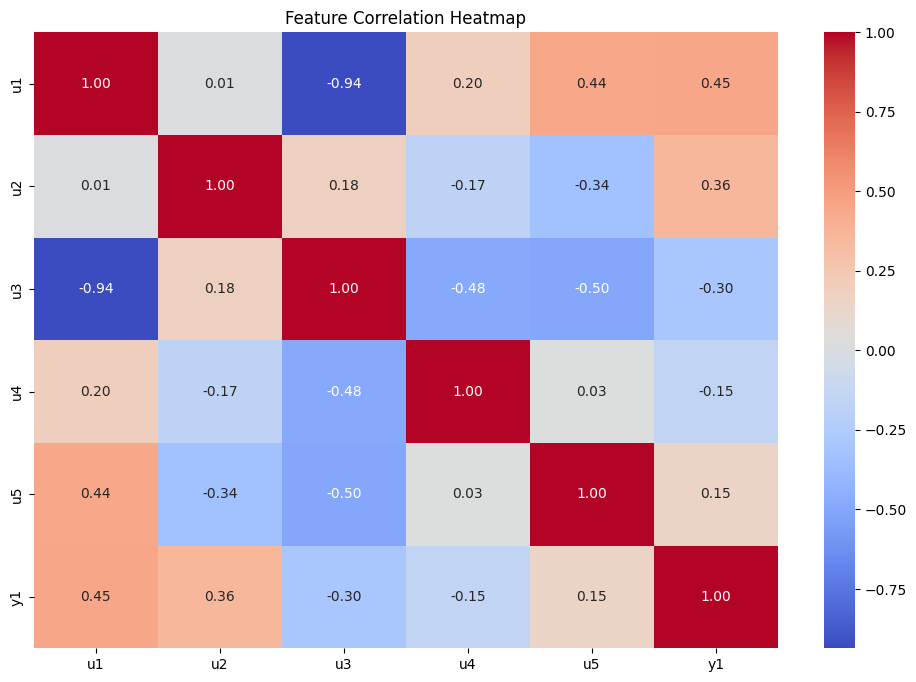

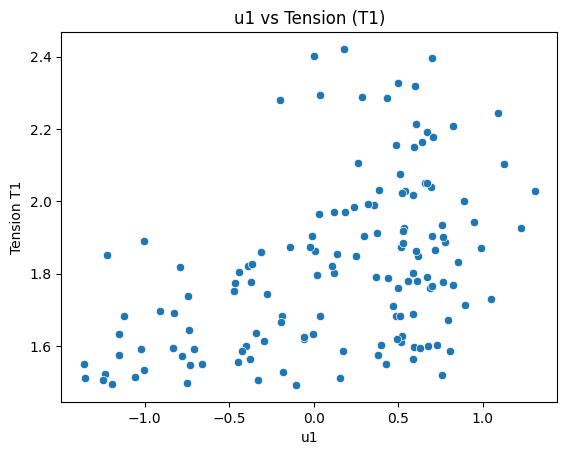

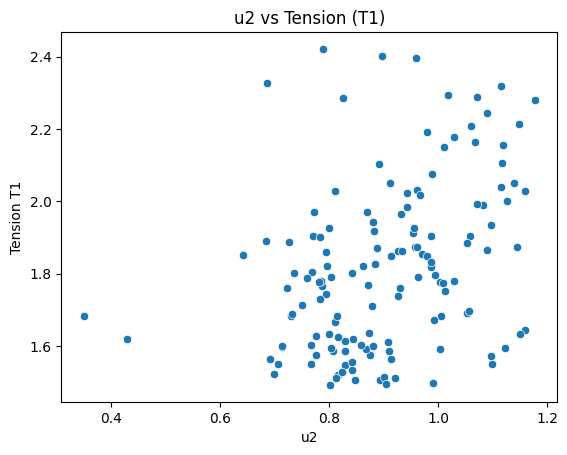

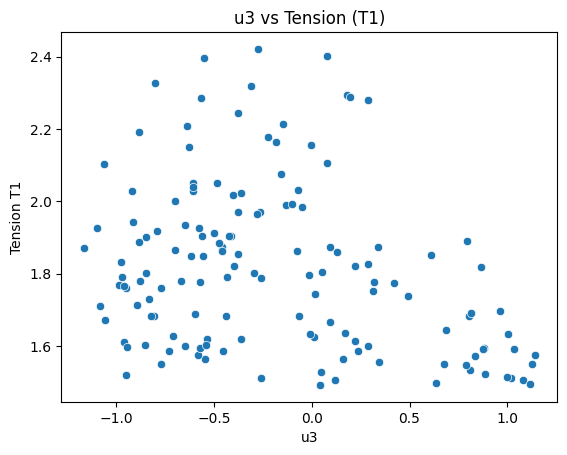

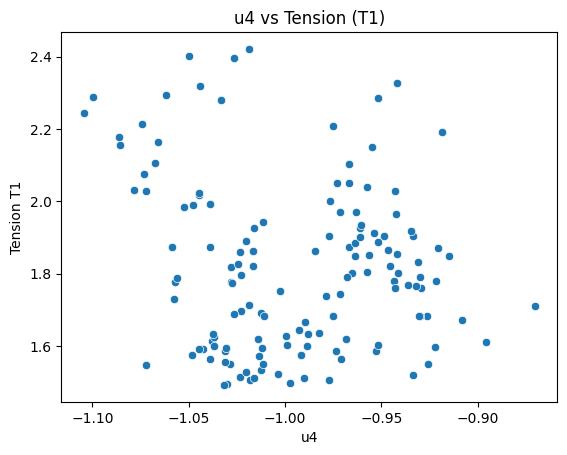

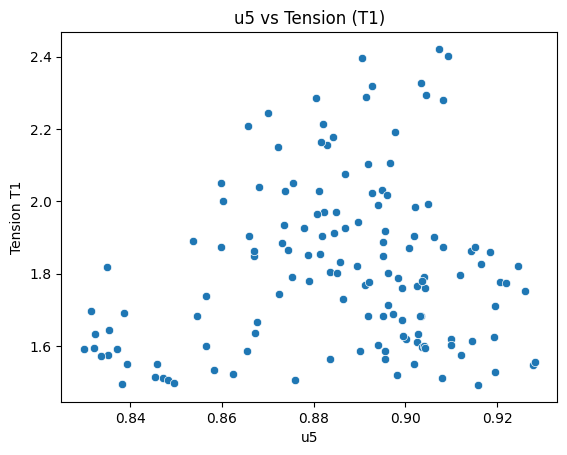

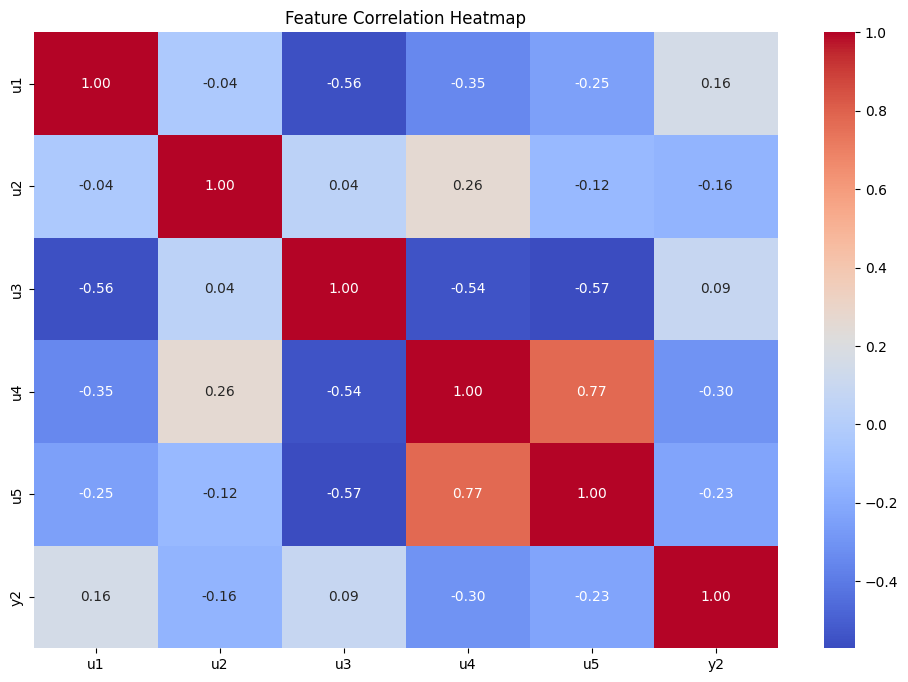

Negative U5


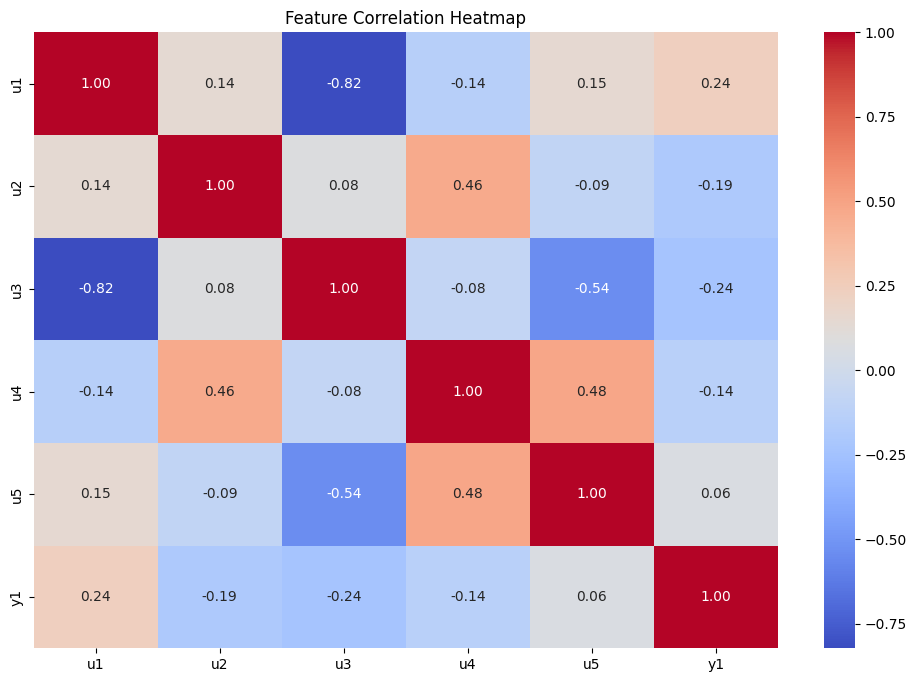

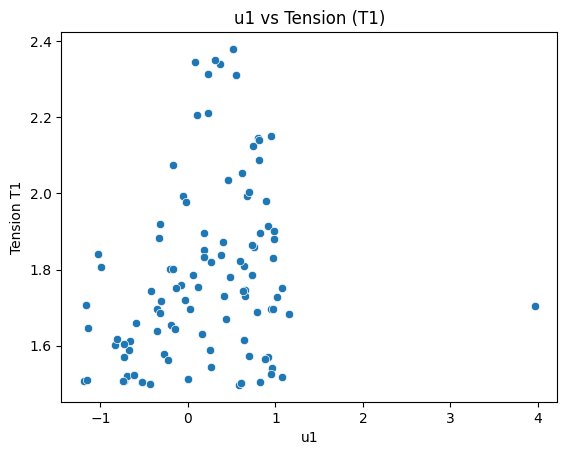

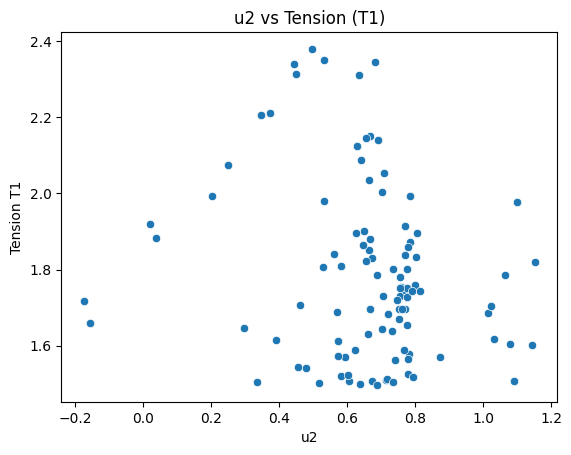

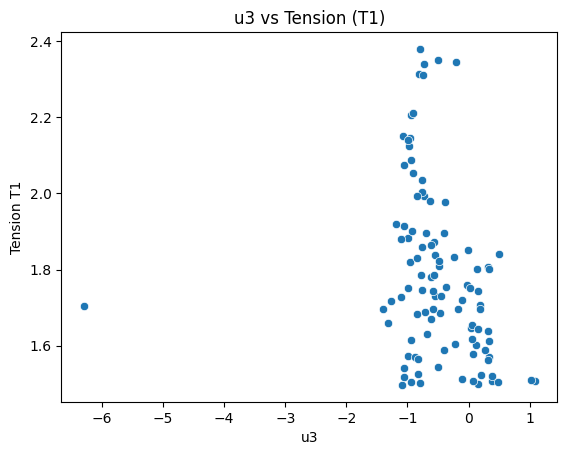

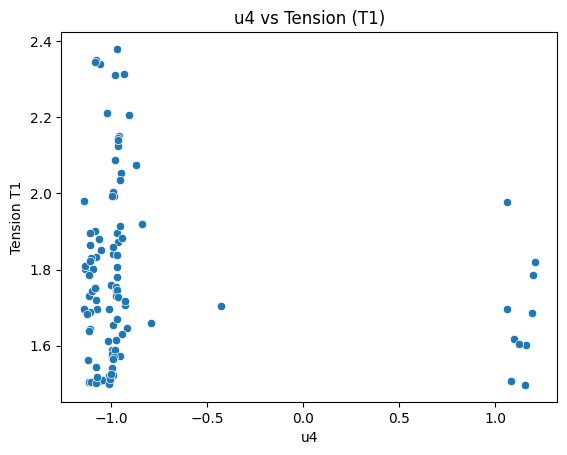

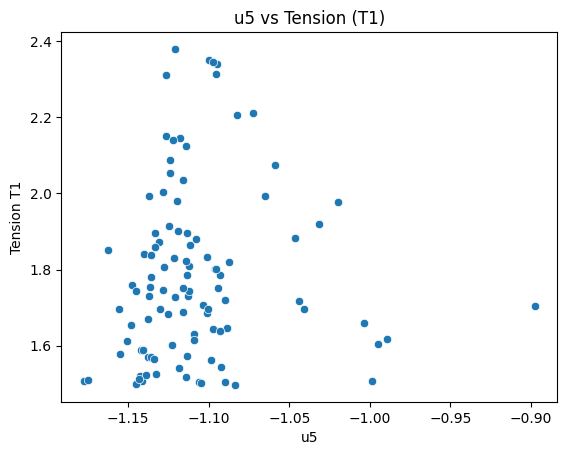

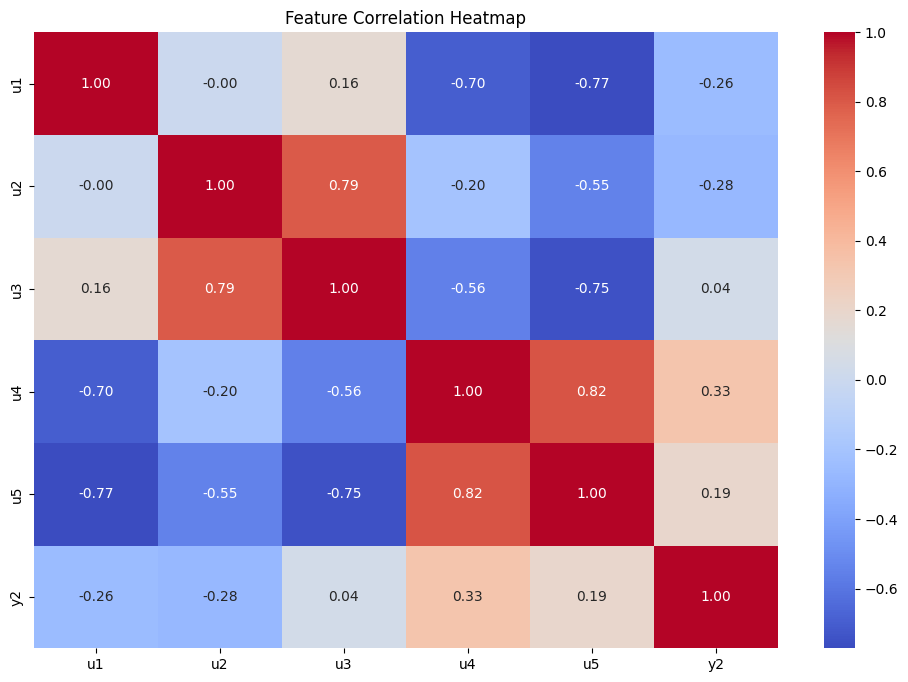

Model for Outliers
Model Performance: MSE = 0.0440, R² Score = 0.2530
------
Defects Per Million Opportunities (DPMO): 31000.00
Process Capability Index (Cpk): 1.01


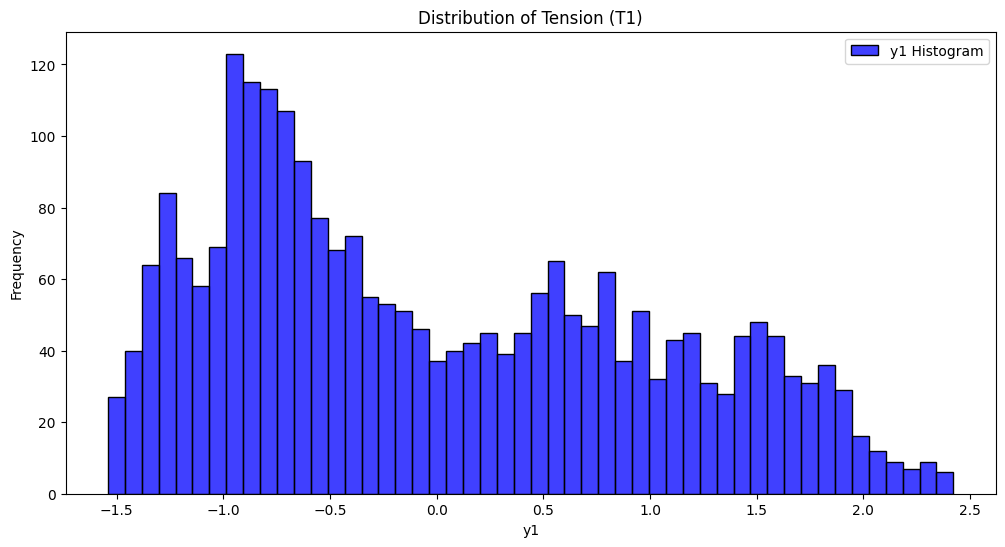

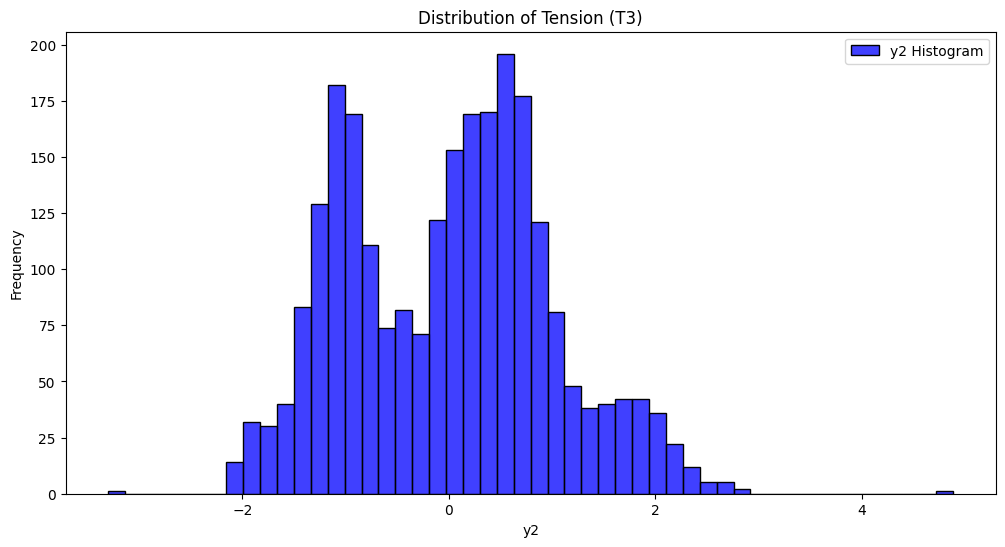

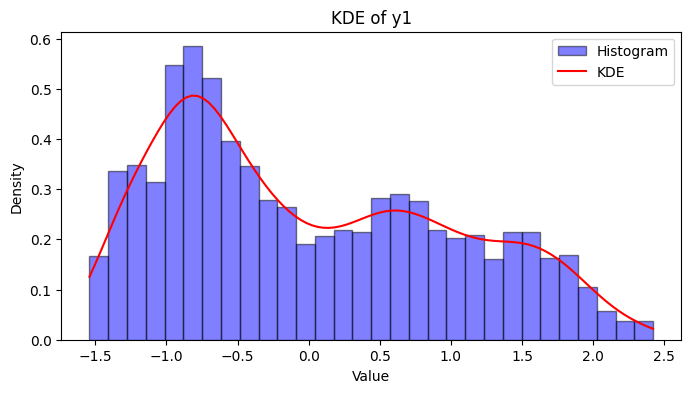

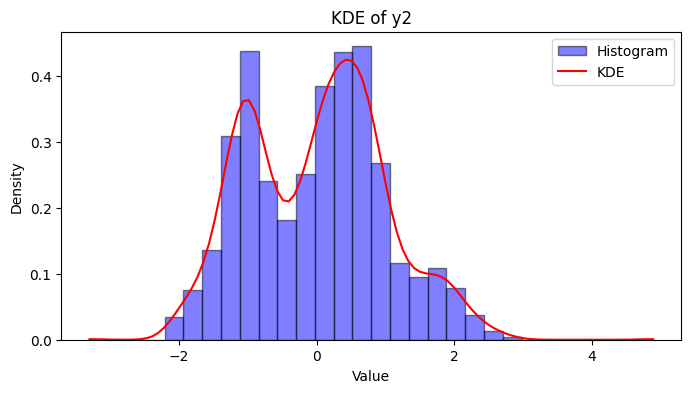

Accuracy: 0.85
Classification Report:
               precision    recall  f1-score   support

           0       0.85      1.00      0.92       106
           1       0.00      0.00      0.00        19

    accuracy                           0.85       125
   macro avg       0.42      0.50      0.46       125
weighted avg       0.72      0.85      0.78       125



c:\Users\jamie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\jamie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\jamie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\U

In [186]:
# Load and preprocess the dataset
file_path = 'processData.csv'  # Update this with the actual dataset path
X_train, X_test, y_train, y_test, data = preprocess_data(file_path)

# Perform EDA
perform_eda(data)

# Train the predictive model
model = train_model(X_train, y_train)

# Evaluate the model
mse, r2, y_pred = evaluate_model(model, X_test, y_test)
print(f'Model Performance: MSE = {mse:.4f}, R² Score = {r2:.4f}')

#Threshold
thresholdy1 = y_test['y1'].mean() + 1.5*y_test['y1'].std()
print("Threshold = " + str(thresholdy1))
thresholdy2 = y_test['y2'].mean() + 1.5*y_test['y2'].std() 

# Quality Control Integration
plot_spc_chart(y_test['y1'], thresholdy1, 'T1')
plot_spc_chart(y_test['y2'], thresholdy2, 'T3')

trigger_alarm(y_pred, threshold=thresholdy1)  # Set the threshold for alarms

#Gather Outliers
outliersy1 = findOutliers(data, thresholdy1, 'y1')
outliersy1 = outliersy1.drop(columns='y2', axis=1)
outliersy2 = findOutliers(data, thresholdy2, 'y2')
outliersy2 = outliersy2.drop(columns='y1',axis=1)

#plot outliers
perform_eda(outliersy1)
perform_eda(outliersy2)

#Try Outliers only Positive U4
print('positive U5')
perform_eda(onlyPositive(outliersy1))
perform_eda(onlyPositive(outliersy2))

#Try Outliers only Negative U4
print('Negative U5')
perform_eda(onlyNegative(outliersy1))
perform_eda(onlyNegative(outliersy2))

#Model for Outliers 
print('Model for Outliers')
X_train2, X_test2, y_train2, y_test2, data2 = preprocess_data_From_Frame(onlyPositive(outliersy1), 'y1')
model2 = train_model(X_train2, y_train2)
mse2, r22, y_pred2 = evaluate_model(model2, X_test2, y_test2)
print(f'Model Performance: MSE = {mse2:.4f}, R² Score = {r22:.4f}')
print('------')


# Six Sigma Analysis
dpmk = calculate_dpmk(y_test.values, y_pred, thresholdy1, thresholdy2)
cpk = calculate_cpk(y_test.values, usl=thresholdy1, lsl=-thresholdy1)  # Example upper and lower spec limits
print(f'Defects Per Million Opportunities (DPMO): {dpmk:.2f}')
print(f'Process Capability Index (Cpk): {cpk:.2f}')

# Compute defects count
defects = np.sum((y_test.values > thresholdy1) | (y_test.values < -thresholdy1))
total_opportunities = len(y_test)


# Plot distribution for Tension T1 (y1) and Tension T3 (y2)
plot_distribution(data, 'y1', 'Tension (T1)')
plot_distribution(data, 'y2', 'Tension (T3)')

# Plot KDE for Tension T1 (y1) and Tension T3 (y2)
plot_kde_manual(data, 'y1')
plot_kde_manual(data, 'y2')


#Train Classifier
toClassify = classify_data(data, 'y1', thresholdy1, thresholdy2)


X = toClassify.drop(columns=['classi'])  
y = toClassify[['classi']]  
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

classifier = train_classifier(X_train, y_train)

evaluate_classifier(classifier, X_test, y_test)
